<a href="https://colab.research.google.com/github/rhrokib/bangla_vulgarity_detection/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import numpy as np 
import pandas as pd



#Dataset

In [5]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/thesis_project/preprocessed_dataset1.csv', na_values='nan')
df.drop(columns=['Unnamed: 0'], inplace=True)

train_data, test_data = train_test_split(df, random_state=7654, stratify=df['target'])

In [6]:
training_sentences = []
testing_sentences = []
training_labels = train_data['target']
testing_labels = test_data['target']

for t in train_data['text']:
  training_sentences.append(str(t))

for t in test_data['text']:
  testing_sentences.append(str(t))

In [7]:
testing_labels = np.array(testing_labels)
training_labels = np.array(training_labels)

In [8]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)


#Model V0.1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 164,429
Trainable params: 164,429
Non-trainable params: 0
_________________________________________________________________


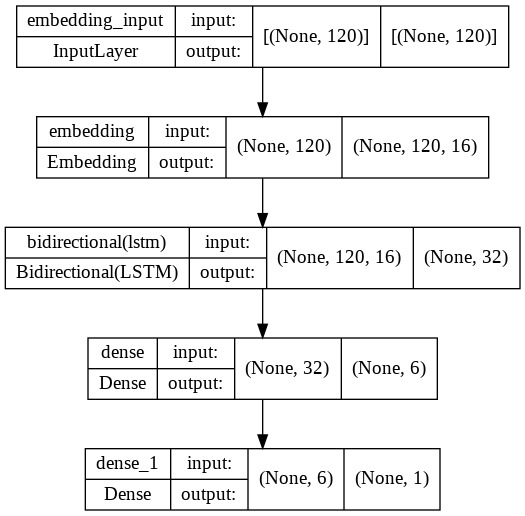

In [9]:
from tensorflow.keras.utils import plot_model

model  = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  # tf.keras.layers.Flatten(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [7]:
num_epochs = 2
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
# model.fit(padded,
#           training_labels,
#           epochs=num_epochs,
#           validation_data=(testing_padded, testing_labels))
history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/2
467/467 - 129s - loss: 0.4038 - accuracy: 0.8029 - val_loss: 0.2842 - val_accuracy: 0.8805 - 129s/epoch - 276ms/step
Epoch 2/2
467/467 - 130s - loss: 0.1689 - accuracy: 0.9336 - val_loss: 0.2907 - val_accuracy: 0.8805 - 130s/epoch - 278ms/step


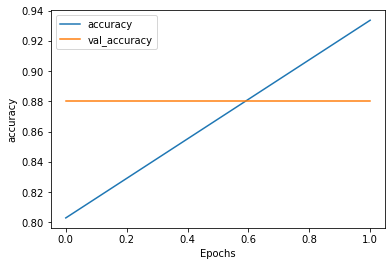

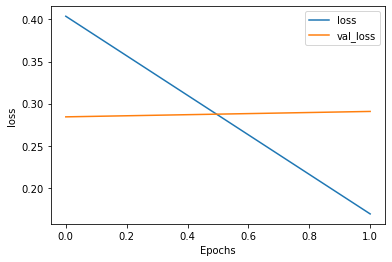

In [8]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [9]:
pred = (model.predict(testing_padded) > 0.5).astype(int)

#Embedding Vector

In [10]:
%%script false

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


e = model.layers[0]
weights = e.get_weights()[0]

#To save the embedding vector_meta
import io

def save_vector(vocab_size, reverse_word_index, weights):
    out_v = io.open('vectors/vecs.tsv', 'w', encoding='utf-8')
    out_m = io.open('vectors/meta.tsv', 'w', encoding='utf-8')
    for word_num in range(1, vocab_size):
        word = reverse_word_index[word_num]
        embeddings = weights[word_num]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
        out_v.close()
        out_m.close()
        
        
#save_vector(vocab_size, reverse_word_index, weights)

CalledProcessError: ignored

#Testing with manual input

In [11]:
sen = ['তোরে চুদি', 'কুত্তার বাচ্চা', 'তুমি ভালো আছো?', 'খানকি মাগি তোর ভাত আর খামু না', 'শুকরের বাচ্চা গুলো ঘুমাচ্ছে']

test_sequences = tokenizer.texts_to_sequences(sen)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

print(model.predict(test_padded)) 

[[0.9922896 ]
 [0.9911958 ]
 [0.2792334 ]
 [0.99752927]
 [0.9208307 ]]


#Saving a model

In [12]:
# model.save('saved_models/LSTM_BI2.h5')

#Loading a pre-saved model

In [ ]:
# new_model = tf.keras.models.load_model('saved_models/LSTM_BI2.h5')